# Preparando datos de entrenamiento y validacion para filtro basado en contenido!

## Cargo los datos

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import ast

/home/brian/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
#!mkdir -p data_anime && unzip -q ./user-animelist-dataset.zip -d data_anime
path = '../data_anime'
anime  = pd.read_csv(f"{path}/animes.csv")
rating = pd.read_csv(f"{path}/ratings.csv")
print(anime.shape)
print(rating.shape)

(20237, 12)
(148170496, 3)


In [3]:
# First, we need to change the data types to obtain reliable results later on.
anime['year']  = pd.to_numeric(anime['year'], errors='coerce').astype('Int64')
anime['score'] = pd.to_numeric(anime['score'], errors='coerce')
anime.dtypes
anime['genres'] = anime['genres'].apply(ast.literal_eval)
anime['genres_detailed'] = anime['genres_detailed'].apply(ast.literal_eval)

In [4]:
display(anime.head())
display(rating.head())


,animeID,title,alternative_title,type,year,score,episodes,mal_url,sequel,image_url,genres,genres_detailed
0,1,Howl's Moving Castle,Howl no Ugoku Shiro,MOVIE,2004,8.41,1,https://myanimelist.net/anime/431,False,https://cdn.myanimelist.net/images/anime/1470/...,"[Adventure, Award Winning, Drama, Fantasy, Rom...","[action, adventure, age gap, air force, anti-w..."
1,2,Death Note,NaN,TV,2006,8.63,37,https://myanimelist.net/anime/1535,False,https://cdn.myanimelist.net/images/anime/1079/...,"[Supernatural, Suspense]","[achronological order, acting, adapted into ja..."
2,3,Problem Children Are Coming from Another World...,Mondaiji-tachi ga Isekai kara Kuru Sou desu yo?,TV,2013,7.42,10,https://myanimelist.net/anime/15315,False,https://cdn.myanimelist.net/images/anime/12/43...,"[Action, Comedy, Fantasy]","[action, alternative world, anthropomorphism, ..."
3,4,BTOOOM!,Btooom!,TV,2012,7.34,12,https://myanimelist.net/anime/14345,False,https://cdn.myanimelist.net/images/anime/4/409...,"[Action, Sci-Fi, Suspense]","[achronological order, action, adventure, age ..."
4,5,Sword Art Online,NaN,TV,2012,7.50,25,https://myanimelist.net/anime/11757,False,https://cdn.myanimelist.net/images/anime/11/39...,"[Action, Adventure, Fantasy, Romance]","[action, action drama, adventure, alternative ..."


,userID,animeID,rating
0,1,1,10
1,1,2,10
2,1,3,7
3,1,4,10
4,1,5,10


Ok, en principio quiero dos sets separados, uno de usuarios y sus caracteristicas y otro de items y sus caracteristicas.
En este caso me interesan todas las caracteristicas menos 'mal_url' , 'sequel', 'image_url'

**Set anime**
- Tirar las columnas  'mal_url' , 'sequel'y 'image_url'
- Los generos son string, habría que convertirlos a vector.
- El score gloabl podria servir

**Set user**
- Solo tiene userID, animeID y sus ratings, voy a necesitar un rating para cada genero.
- usando el animeID, voy a ver los genero y decir una forma de darle un rating a cada genero en base a sus ratings individuales.

**Set ratings**
-  por cada par anime user tiene que haber un ratinga predecir.

**Busco la mayor cantidad de datos posibles**

## Filtrado Anime

In [35]:
df_analize_anime = anime.drop(columns=['alternative_title', 'mal_url' , 'sequel', 'image_url'])

df_analize_anime.info()
print(df_analize_anime['type'].value_counts())
print(df_analize_anime['genres'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20237 entries, 0 to 20236
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   animeID          20237 non-null  int64  
 1   title            20237 non-null  object 
 2   type             20237 non-null  object 
 3   year             20101 non-null  Int64  
 4   score            19644 non-null  float64
 5   episodes         20237 non-null  int64  
 6   genres           20237 non-null  object 
 7   genres_detailed  20237 non-null  object 
dtypes: Int64(1), float64(1), int64(2), object(4)
memory usage: 1.3+ MB
type
TV         5766
SPECIAL    4847
OVA        3661
MOVIE      3250
ONA        2713
Name: count, dtype: int64
genres
[Comedy]                                   2224
[Hentai]                                   1305
[Fantasy]                                   821
[Slice of Life]                             755
[Action]                                    609
  

Veamos las columnas de generos y generos detallados a ver si me pueden servir ambos o solo uno

In [38]:
df_analize_anime.dropna(inplace=True)
#to lowe, eliminar caracteres extraños, dentro tienen una lista con generos y generos detallados repsectivasmente
def norm_strings(list_generes):
    """
    recibe una lista de generos y los lleva minusculas, elimna caracteres raros...
    """
    return [x.lower().replace("\n", "") for x in list_generes]

df_analize_anime["genres"]          = df_analize_anime["genres"].apply(norm_strings)
df_analize_anime["genres_detailed"] = df_analize_anime["genres_detailed"].apply(norm_strings)


display(df_analize_anime["genres"].explode().value_counts())
display(df_analize_anime["genres_detailed"].explode().value_counts())

genres
comedy           6711
action           5223
fantasy          4513
adventure        3579
sci-fi           3153
drama            2767
romance          2162
hentai           1599
supernatural     1504
slice of life    1395
mystery           957
ecchi             829
avant garde       787
sports            724
horror            564
suspense          443
award winning     242
boys love         187
gourmet           174
girls love        116
erotica            68
Name: count, dtype: int64

genres_detailed
japanese production    10938
comedy                  9874
action                  7818
fantasy                 7194
present                 6981
                       ...  
war drama                  1
bi-shounen                 1
self-identification        1
sand pirates               1
magical weapons            1
Name: count, Length: 2985, dtype: int64

Momento!!! los generos no son muchos! pero si son muchos los generos detallados.

Estos pueden dar mejor informacion para el usuario pero no necesariamente es lo mas importante.

Exploremos


(2985,)
high: 313.0, low: 136.0
(303,)


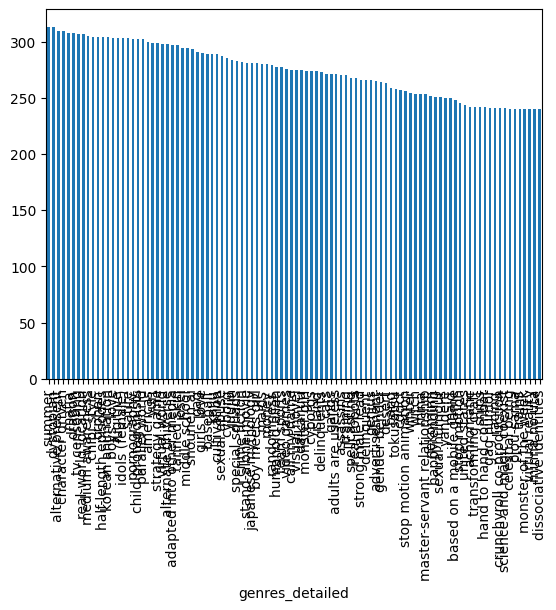

genres_detailed
chuunibyou                 140
united kingdom             139
university                 139
cult                       137
pirate                     137
19th century               136
knight                     136
extrasensory perception    136
shounen-ai                 136
pets                       136
Name: count, dtype: int64


In [ ]:
from numpy import quantile


aux = df_analize_anime["genres_detailed"].explode().value_counts()
aux = aux.sort_values(ascending=False)
print(aux.shape)

#de estos generos quiero elegir el 10% mas popular, usando quantile.
# pero hay unos quue siempre van a estar y port ello no aportan informacion, quiero sacar los mas populares
high, low = aux.quantile(0.90), aux.quantile(0.80)
print(f"high: {high}, low: {low}")
aux = aux[(aux >= low) & (aux <= high)]

print(aux.shape)
#Quiero hacer un grafico!
aux.head(100).plot(kind="bar")
plt.show()



print(aux.tail(10))


Se elegio tomar por los generos por percentiles, quedaron muchos dentro del rango entre 80-90 pero aun asi se espera que sean representativos de los gustos del usuario.

In [40]:
genres_select = df_analize_anime["genres_detailed"].explode().value_counts().sort_values(ascending=False)
high, low = genres_select.quantile(0.90), genres_select.quantile(0.80)
genres_select = genres_select[(genres_select >= low) & (genres_select <= high)]

generes_select_list = genres_select.index.to_list() #global la porqueria esta.
#aca tengo la lista de generos permitidos, debo recorrer todos las filas de generos detallados y dejar solo los generos que estan en la lista.

def filter_genres(x):
    """
    recibe una lista de generos y retorna solo los generos que estan en la lista generes_select_list
    """
    return [i for i in x if i in generes_select_list]

df_analize_anime["genres_detailed"] = df_analize_anime["genres_detailed"].apply(filter_genres)
df_analize_anime.head()

,animeID,title,type,year,score,episodes,genres,genres_detailed
0,1,Howl's Moving Castle,MOVIE,2004,8.41,1,"[adventure, award winning, drama, fantasy, rom...","[air force, anti-war, aviation, award winning,..."
1,2,Death Note,TV,2006,8.63,37,"[supernatural, suspense]","[achronological order, acting, adapted into ja..."
2,3,Problem Children Are Coming from Another World...,TV,2013,7.42,10,"[action, comedy, fantasy]","[battle royale, delinquents, fairy, fairy tale..."
3,4,BTOOOM!,TV,2012,7.34,12,"[action, sci-fi, suspense]","[achronological order, battle royale, betrayal..."
4,5,Sword Art Online,TV,2012,7.50,25,"[action, adventure, fantasy, romance]","[awards, damsel in distress, dungeon, fairy, g..."


In [41]:
def unionGenres(row):
    """
    Une los generos de "genres" y "genres_detailed", evita generos duplicados.
    """
    return list(set(row["genres"] + row["genres_detailed"]))


df_analize_anime["genres_union"] = df_analize_anime.apply(unionGenres, axis=1)

df_analize_anime.head()

,animeID,title,type,year,score,episodes,genres,genres_detailed,genres_union
0,1,Howl's Moving Castle,MOVIE,2004,8.41,1,"[adventure, award winning, drama, fantasy, rom...","[air force, anti-war, aviation, award winning,...","[folklore, maids, steampunk, boy meets girl, d..."
1,2,Death Note,TV,2006,8.63,37,"[supernatural, suspense]","[achronological order, acting, adapted into ja...","[united states, genius, weekly shounen jump, s..."
2,3,Problem Children Are Coming from Another World...,TV,2013,7.42,10,"[action, comedy, fantasy]","[battle royale, delinquents, fairy, fairy tale...","[maid, genius, mundane made awesome, folklore,..."
3,4,BTOOOM!,TV,2012,7.34,12,"[action, sci-fi, suspense]","[achronological order, battle royale, betrayal...","[suspense, tv censoring, action, betrayal, sex..."
4,5,Sword Art Online,TV,2012,7.50,25,"[action, adventure, fantasy, romance]","[awards, damsel in distress, dungeon, fairy, g...","[mutilation, fairy, sexual abuse, dungeon, rap..."


Existen en los generos detallados generos existentes en la columna de generos, para no perder informacion se los va a unir.

>Nota: esstos generos pueden ser metidos a un encoder ya entrenado y obtener un embedding, en nuestro caso vamos a usart OneHot por ser lo usual pero para hilar fino es recomendable pasarlo a un vector mas representativo y ademas ocupa poco, sin embargo esto lleva a aumentar la complegidad en el set de usuarios en donde ya no es tan simple poner una calificación por genero si no generos explicitos en items (aunque pudo asignarlos igual e igualmente codificar las uniones de generos.. decisiones al tomar en el momento de entrenar).

In [42]:
df_analize_anime.drop(columns=['genres', 'genres_detailed'], inplace=True)
df_analize_anime.head()

,animeID,title,type,year,score,episodes,genres_union
0,1,Howl's Moving Castle,MOVIE,2004,8.41,1,"[folklore, maids, steampunk, boy meets girl, d..."
1,2,Death Note,TV,2006,8.63,37,"[united states, genius, weekly shounen jump, s..."
2,3,Problem Children Are Coming from Another World...,TV,2013,7.42,10,"[maid, genius, mundane made awesome, folklore,..."
3,4,BTOOOM!,TV,2012,7.34,12,"[suspense, tv censoring, action, betrayal, sex..."
4,5,Sword Art Online,TV,2012,7.50,25,"[mutilation, fairy, sexual abuse, dungeon, rap..."


In [44]:
df_analize_anime["genres_union"].explode().value_counts().reset_index()

,genres_union,count
0,comedy,6711
1,action,5223
2,fantasy,4513
3,adventure,3579
4,sci-fi,3153
...,...,...
315,shounen-ai,136
316,knight,136
317,19th century,136
318,pets,136


In [ ]:
##top_users = 100
##
##df = df_top_quantile
##
##plt.figure(figsize=(20, 14))
##sns.barplot(data=df, x='genres_union', y='count', order=df['genres_union'], palette='viridis')
##plt.title(f'Top {top_users} Usuarios Más Activos', fontsize=20, fontweight='bold')
##plt.xlabel('Generos', fontsize=16)
##plt.ylabel('Número de Calificaciones', fontsize=16)
##df = df["genres_union"].explode().value_counts().reset_index()
##
##df.columns = ['genres_union', 'count']
##df = df.sort_values('count', ascending=False).head(top_users)
##plt.grid(axis='y', linestyle='--', alpha=0.7)
##plt.xticks(rotation=90)
##plt.tight_layout()  # Ajusta el diseño para que todo quepa
##plt.show()

Aplico los cambios, me quedo con los que contentan esos generos unidos.

Veamos los de la colunmna type.

Son pocos, podria sser simplemente un OneHot ni los toco a fin de tenes mas datos

In [45]:
display(df_analize_anime["type"].explode().value_counts())

type
TV         5552
SPECIAL    4691
OVA        3615
MOVIE      3138
ONA        2602
Name: count, dtype: int64

Bueno, son muchos generos detallados y algunos repetidos, no creo que valga la pena filtrar y demas, ya que 
se tiene pensado usar NN, se va a usar en un encoder para cada combinación de generos y generos detallados, no importas si se repiten los detallados.

Donde si se va a hacer un one hot será en los types o podria filtrar solo por el type=TV pero quiero la mayor cantidad de datos dado que se va a entrenar una red neuronal!

In [46]:
df_analize_anime

,animeID,title,type,year,score,episodes,genres_union
0,1,Howl's Moving Castle,MOVIE,2004,8.41,1,"[folklore, maids, steampunk, boy meets girl, d..."
1,2,Death Note,TV,2006,8.63,37,"[united states, genius, weekly shounen jump, s..."
2,3,Problem Children Are Coming from Another World...,TV,2013,7.42,10,"[maid, genius, mundane made awesome, folklore,..."
3,4,BTOOOM!,TV,2012,7.34,12,"[suspense, tv censoring, action, betrayal, sex..."
4,5,Sword Art Online,TV,2012,7.50,25,"[mutilation, fairy, sexual abuse, dungeon, rap..."
...,...,...,...,...,...,...,...
20230,20231,Okamoto Zero One CM Dinosaur Edition,SPECIAL,2016,5.87,1,"[explicit sex, commercials, ecchi, comedy]"
20231,20232,Girls★Battle Aloe Megumi,TV,2008,5.00,24,"[action, comedy]"
20232,20233,Manabu no Natsuyasumi,OVA,2005,4.95,1,"[mina, japanese mythology, fantasy, child prot..."
20235,20236,Fuwa's Olympic Stories,TV,2007,4.82,100,"[half-length episodes, china]"


En esta etapa no vale la pena hacer el one-hot encoding ya que es decisión del usuario si usar One Hot Encoding u otro metodo de encoding.

> se procede a guardar el dataFrame como **item_name.csv** este el setr de items final que se usara, puesto que falta mayor procesamiento para obtener el users y el de ratings / interacciones.


In [ ]:
#type_ohe = pd.get_dummies(df_analize_anime["type"], prefix="type").astype(int)
#genres_ohe = pd.get_dummies(df_analize_anime["genres_union"], prefix="genre_union").astype(int)
#item_features = pd.concat([df_analize_anime, type_ohe, genres_ohe], axis=1).drop(columns=["type", "genres_union"])

#item_features.set_index("animeID", inplace=True)

In [47]:
df_analize_anime.to_csv("../data_anime/item_anime.csv", index=False)

> NOTA: los siguientes sets de interacciones y usuarios se vuelve muy pesados! tanto por cantidad de generos como mismas interracciones, para ello se opta por trabajar con Spark (tambien es una escusa para usarlo)

> Para trabajar con spark y que nada se rompa es mejor tener los archivos en formatoi parquet.


In [53]:
rating.to_parquet(
            "../data_anime/rating.parquet",
            engine="pyarrow",
            compression="snappy",
            index=False
    )

df_analize_anime.to_parquet(
        "../data_anime/anime.parquet",
        engine="pyarrow",
        compression="snappy",
        index=False
)

rating_spark = pd.read_parquet("../data_anime/rating.parquet")
anime_spark  = pd.read_parquet("../data_anime/anime.parquet")

display(rating_spark.head())
display(anime_spark.head())


,userID,animeID,rating
0,1,1,10
1,1,2,10
2,1,3,7
3,1,4,10
4,1,5,10


,animeID,title,type,year,score,episodes,genres_union
0,1,Howl's Moving Castle,MOVIE,2004,8.41,1,"[folklore, maids, steampunk, boy meets girl, d..."
1,2,Death Note,TV,2006,8.63,37,"[united states, genius, weekly shounen jump, s..."
2,3,Problem Children Are Coming from Another World...,TV,2013,7.42,10,"[maid, genius, mundane made awesome, folklore,..."
3,4,BTOOOM!,TV,2012,7.34,12,"[suspense, tv censoring, action, betrayal, sex..."
4,5,Sword Art Online,TV,2012,7.50,25,"[mutilation, fairy, sexual abuse, dungeon, rap..."


Listo tengo mis datos de items!

In [48]:
df_analize_anime = pd.read_csv("../data_anime/item_anime.csv")
df_analize_anime['genres_union'] = df_analize_anime['genres_union'].apply(ast.literal_eval)
df_analize_anime.head()


,animeID,title,type,year,score,episodes,genres_union
0,1,Howl's Moving Castle,MOVIE,2004,8.41,1,"[folklore, maids, steampunk, boy meets girl, d..."
1,2,Death Note,TV,2006,8.63,37,"[united states, genius, weekly shounen jump, s..."
2,3,Problem Children Are Coming from Another World...,TV,2013,7.42,10,"[maid, genius, mundane made awesome, folklore,..."
3,4,BTOOOM!,TV,2012,7.34,12,"[suspense, tv censoring, action, betrayal, sex..."
4,5,Sword Art Online,TV,2012,7.50,25,"[mutilation, fairy, sexual abuse, dungeon, rap..."
